<a href="https://colab.research.google.com/github/MRB1996/Titanic-Learning-From-Disaster/blob/master/Titanic_Learning_From_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Learning From Disaster

* Melchior Reihlen-Börgers
* [GitHub](https://github.com/MRB1996/Titanic-Learning-From-Disaster)

In [0]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.neural_network import MLPClassifier


font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [0]:
os.getcwd()

os.chdir("/content/drive/My Drive/Titanic Data Science Challenge")

## 1. Import Data

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [0]:
for index, col_name in enumerate(train.columns):
  print(index, col_name)

0 PassengerId
1 Survived
2 Pclass
3 Name
4 Sex
5 Age
6 SibSp
7 Parch
8 Ticket
9 Fare
10 Cabin
11 Embarked


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 2. Change Data Types

**Recode Sex**

In [0]:
train.loc[:,"Sex"] = train.loc[:,"Sex"].map({"female": 1, "male": 0})

In [0]:
test.loc[:,"Sex"] = test.loc[:,"Sex"].map({"female": 1, "male": 0})

## 3. Assess Cleaniness Of Data

**1. How many rows are empty?**

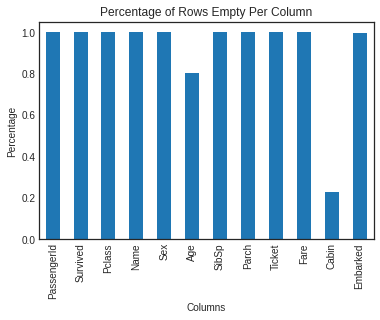

In [0]:
empty_rows = train.apply(lambda x: x.count()/x.size)

empty_rows.plot(kind = "bar")
plt.title("Percentage of Rows Empty Per Column")
plt.xlabel("Columns")
plt.ylabel("Percentage")
plt.show()

* Using Cabin does not seem to be useful
* Age is also not filled out in many cases

## 4. Descriptive Data Analytics

### Survived

1. How many people survived vs. died? How is the survival distributed?

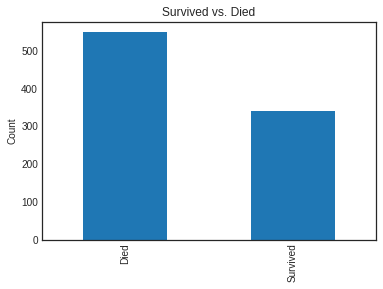

In [0]:
train.loc[:,"Survived"].map({0: "Died", 1: "Survived"}).value_counts().plot(kind = "bar")
plt.title("Survived vs. Died")
plt.ylabel("Count")
plt.show()

2. How old where people that survived, died and in total?


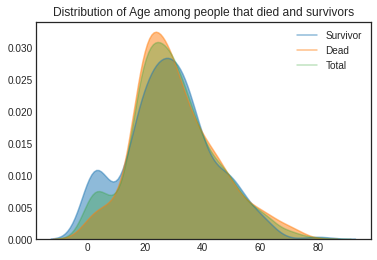

In [0]:
h1 = train[train["Survived"] == 1].loc[:,"Age"]
h2 = train[train["Survived"] == 0].loc[:,"Age"]
h3 = train.loc[:,"Age"]

sns.kdeplot(h1, alpha=0.5, label='Survivor', shade = True)
sns.kdeplot(h2, alpha=0.5, label='Dead', shade = True)
sns.kdeplot(h3, alpha= 0.3, label='Total', shade = True)
plt.legend(loc = 1)
plt.title("Distribution of Age among people that died and survivors")
plt.show()

### Class

1. How many passengers are in each class?

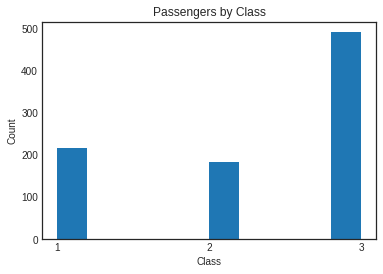

In [0]:
plt.hist(train.loc[:,"Pclass"])
plt.xticks([1,2,3])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Passengers by Class")
plt.show()

2. How many of the passengers are male/female by class?

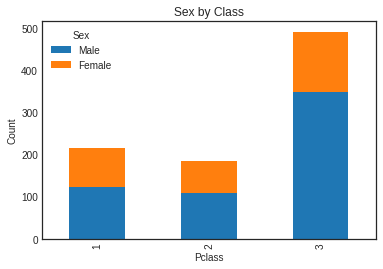

In [0]:
train.loc[:,["Sex", "Pclass"]].groupby("Pclass")["Sex"].value_counts().unstack().rename(columns = {0: "Male", 1:"Female"}).plot(kind = "bar", stacked = True)
plt.title("Sex by Class")
plt.ylabel("Count")
plt.show()

3. How many of the passengers survived by class?

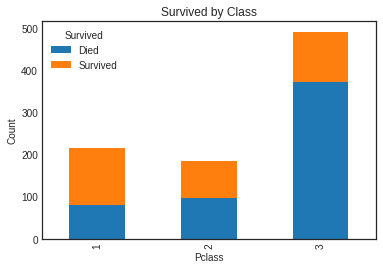

In [0]:
train.loc[:,["Survived", "Pclass"]].groupby("Pclass")["Survived"].value_counts().unstack().rename(columns = {0: "Died", 1:"Survived"}).plot(kind = "bar", stacked = True)
plt.title("Survived by Class")
plt.ylabel("Count")
plt.show()

4. What is the ratio of survivors to people that died by class?

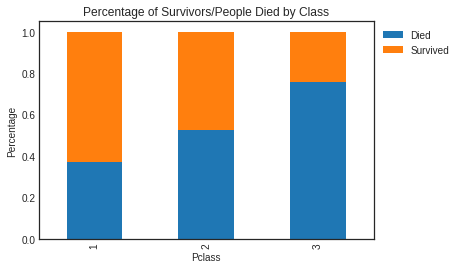

In [0]:
df = train.loc[:,["Survived", "Pclass"]].groupby("Pclass")["Survived"].value_counts().unstack().rename(columns = {0: "Died", 1:"Survived"})

df.div(df.sum(axis = 1), axis = 0).plot(kind = "bar", stacked = True)
plt.ylabel("Percentage")
plt.title("Percentage of Survivors/People Died by Class")
plt.legend(loc = 0, bbox_to_anchor = (1, 1))
plt.show()


### Ticket


In [0]:
percentage_unique = len(train.loc[:,"Ticket"].unique())/train.shape[0]

print("{:.2f}% of Tickets are unique.".format(percentage_unique*100))

76.43% of Tickets are unique.


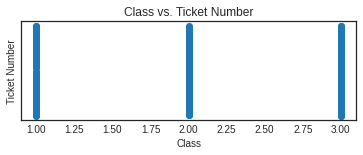

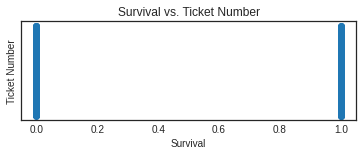

In [0]:
plt.subplot(2, 1, 1)
plt.scatter(x = train.loc[:,"Pclass"], y = train.loc[:,"Ticket"])
plt.yticks([])
plt.xlabel("Class")
plt.ylabel("Ticket Number")
plt.title("Class vs. Ticket Number")
plt.show()

plt.subplot(2, 1, 2)
plt.scatter(x = train.loc[:,"Survived"], y = train.loc[:,"Ticket"])
plt.yticks([])
plt.xlabel("Survival")
plt.ylabel("Ticket Number")
plt.title("Survival vs. Ticket Number")
plt.show()




*   Tickets are mostely unique
*   Tickets does not correlate with major variables



### Siblings/Spouses

1. How is the variable distributed?

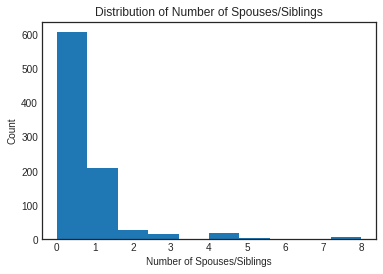

In [0]:
plt.hist(train["SibSp"])
plt.title("Distribution of Number of Spouses/Siblings")
plt.xlabel("Number of Spouses/Siblings")
plt.ylabel("Count")
plt.show()

2. Is there a trend in the number of siblings/spouses on board and the survival?

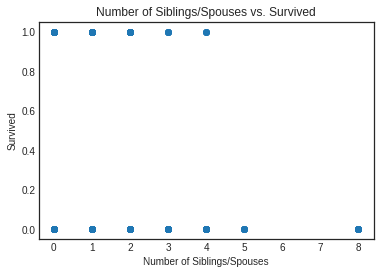

In [0]:
plt.scatter(x = train.loc[:,"SibSp"], y = train.loc[:,"Survived"])
plt.title("Number of Siblings/Spouses vs. Survived")
plt.xlabel("Number of Siblings/Spouses")
plt.ylabel("Survived")
plt.show()

3. Is the number of siblings/spouses related to the class?

* Filter out the passengers traveling on their own.

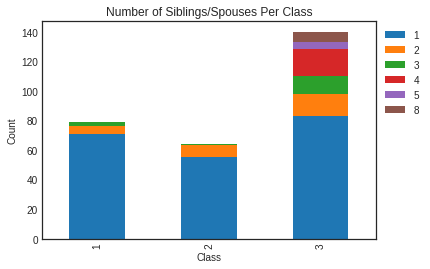

In [0]:
train[train.SibSp.ne(0)].loc[:,["Pclass", "SibSp"]].groupby("Pclass")["SibSp"].value_counts().unstack().plot(kind = "bar", stacked = "True")
plt.legend(loc = 0, bbox_to_anchor = (1,1))
plt.title("Number of Siblings/Spouses Per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Parents/Children

1. How is the variable distributed?

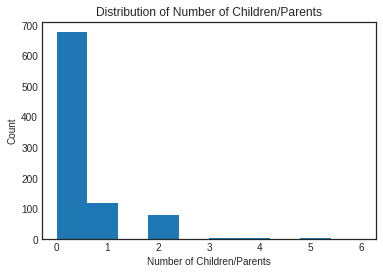

In [0]:
plt.hist(train["Parch"])
plt.title("Distribution of Number of Children/Parents")
plt.xlabel("Number of Children/Parents")
plt.ylabel("Count")
plt.show()

2. Is there a trend in the number of parents/children on board and the survival?

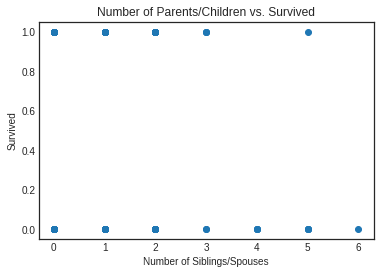

In [0]:
plt.scatter(x = train.loc[:,"Parch"], y = train.loc[:,"Survived"])
plt.title("Number of Parents/Children vs. Survived")
plt.xlabel("Number of Siblings/Spouses")
plt.ylabel("Survived")
plt.show()

3. Is the number of siblings/spouses related to the class?

* Filter out the passengers traveling on their own.

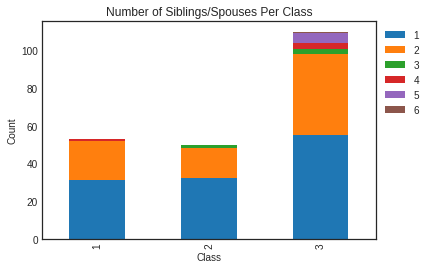

In [0]:
train[train.Parch.ne(0)].loc[:,["Pclass", "Parch"]].groupby("Pclass")["Parch"].value_counts().unstack().plot(kind = "bar", stacked = "True")
plt.legend(loc = 0, bbox_to_anchor = (1,1))
plt.title("Number of Siblings/Spouses Per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Fare

1. How are fares distributed

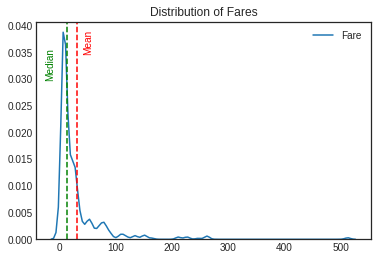

In [0]:
sns.kdeplot(data = train["Fare"])
plt.axvline(train["Fare"].mean(), c = "red", ls = "--")
plt.axvline(train["Fare"].median(), c = "green", ls = "--")
plt.title("Distribution of Fares")
plt.text(train["Fare"].mean() + 10, 0.035, 'Mean',rotation=90, c = "red")
plt.text(train["Fare"].median() - 40, 0.03, 'Median',rotation=90, c = "green")
plt.show()

2. Is there a relationship between the fares and the survival?

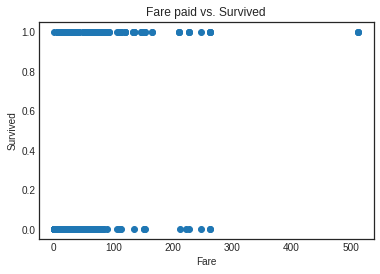

In [0]:
plt.scatter(x = train["Fare"], y = train["Survived"])
plt.title("Fare paid vs. Survived")
plt.xlabel("Fare")
plt.ylabel("Survived")
plt.show()

### Age

1. How is Age distributed?

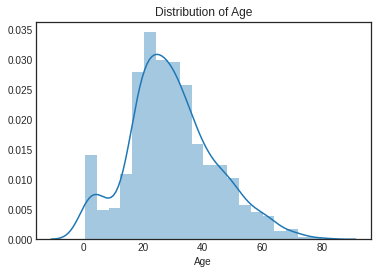

In [0]:
sns.distplot(train.loc[:,"Age"])
plt.title("Distribution of Age")
plt.show()

2. What are the missing columns? Are there any differences?

In [0]:
train["Missing_age"] = np.isnan(train.loc[:,"Age"])

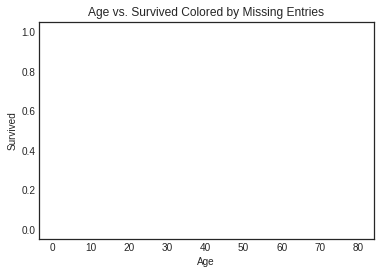

In [0]:
plt.scatter(x = train["Age"], y = train["Survived"], c = train["Missing_age"], alpha = 0.3)
plt.xlabel("Age")
plt.ylabel("Survived")
plt.title("Age vs. Survived Colored by Missing Entries")
plt.show()

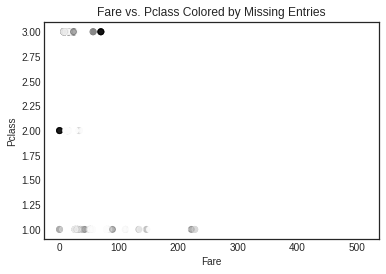

In [0]:
plt.scatter(x = train["Fare"], y = train["Pclass"], c = train["Missing_age"], alpha = 0.3)
plt.xlabel("Fare")
plt.ylabel("Pclass")
plt.title("Fare vs. Pclass Colored by Missing Entries")
plt.show()

### Embarked

1. Is there a difference between people embarking in different ports?

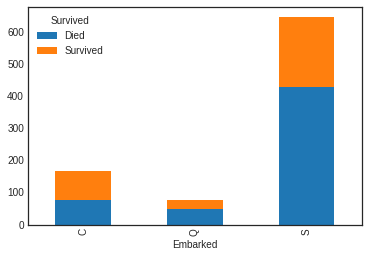

In [0]:
train.loc[:,["Survived", "Embarked"]].groupby("Survived")["Embarked"].value_counts().unstack().rename(index = {0: "Died", 1:"Survived"}).transpose().plot(kind = "bar", stacked = True)
plt.show()

### Correlation Between Features

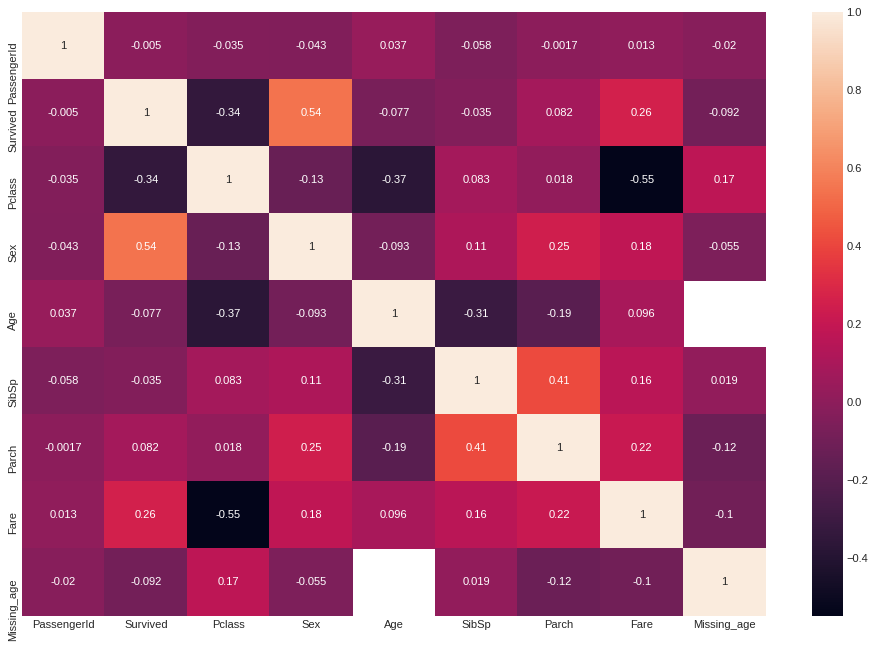

In [0]:
plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(train.corr(), annot= True)
plt.show()

## 5. Model Building - Train Data
* Using only the train data, I make a train test split to evaluate which model performs best out-of-sample to make predictions for the 'true' out-of-sample predictions.

* Create a train test split for the training data (note that for the test data set from Kaggle there are no labels. Evaluation will not be possible)

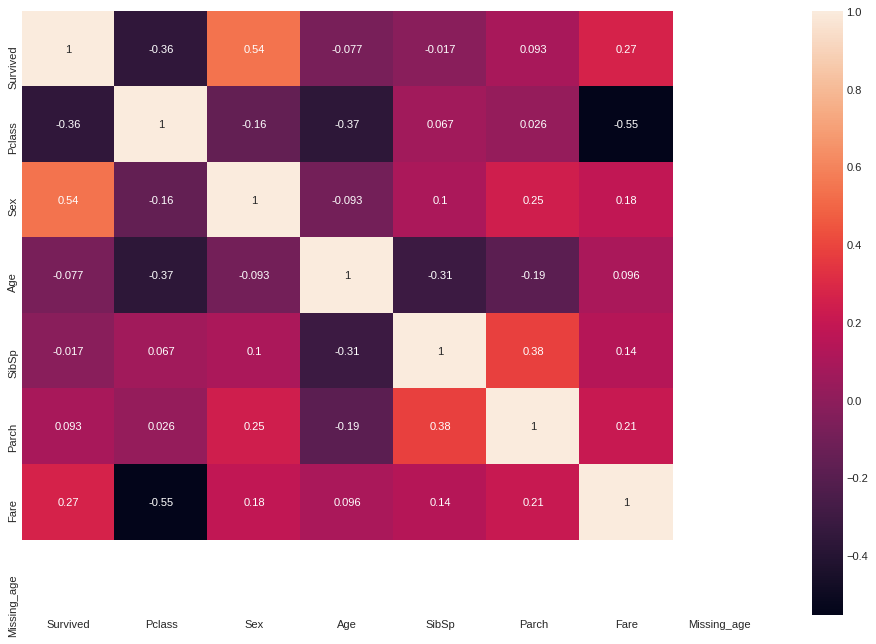

In [0]:
train = train.drop(["Cabin", "PassengerId", "Name", "Ticket", "Embarked"], axis = 1).dropna()
test = test.drop(["Cabin", "PassengerId", "Name", "Ticket", "Embarked"], axis = 1).dropna()

plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(train.corr(), annot= True)
plt.show()

In [0]:
X = train.drop("Survived", axis = 1)
y = train.loc[:,"Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### 5.1 Logistic Regression

In [0]:
logit_model = LogisticRegression()

logit_fit = logit_model.fit(X_train, y_train)

logit_predict_train = logit_fit.predict(X_train)
logit_predict_test  = logit_fit.predict(X_test)

print("The Logistic Regression Classification Report In-Sample: \n \n {}".format(classification_report(y_true = y_train, y_pred = logit_predict_train)))
print("\n The Logistic Regression Classification Report Out-Of-Sample: \n \n {}".format(classification_report(y_true = y_test, y_pred = logit_predict_test)))

The Logistic Regression Classification Report In-Sample: 
 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       346
           1       0.79      0.71      0.75       225

    accuracy                           0.81       571
   macro avg       0.81      0.79      0.80       571
weighted avg       0.81      0.81      0.81       571


 The Logistic Regression Classification Report Out-Of-Sample: 
 
               precision    recall  f1-score   support

           0       0.84      0.83      0.84        78
           1       0.80      0.82      0.81        65

    accuracy                           0.83       143
   macro avg       0.82      0.82      0.82       143
weighted avg       0.83      0.83      0.83       143



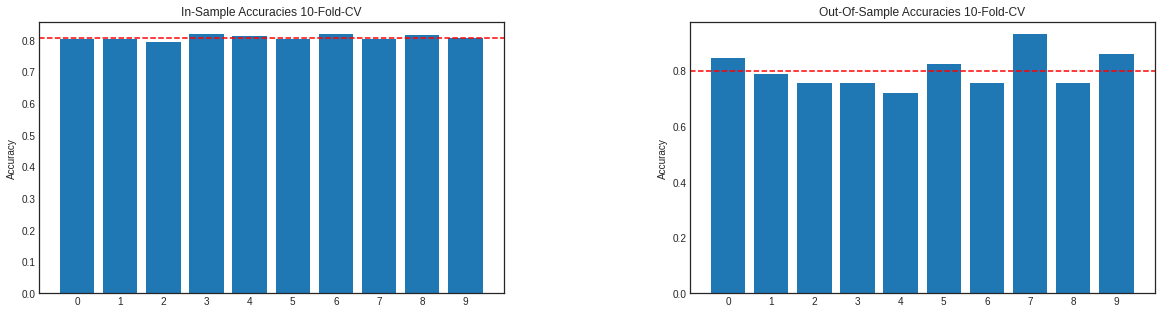

The in-sample mean accuracy is 80.68%. 
 The out-of-sample mean accuracy is 79.85%


In [0]:
pipe_logit = make_pipeline(StandardScaler(), LogisticRegression())

cv = cross_validate(pipe_logit, X_train, y_train, cv = 10, return_train_score= True, return_estimator= True)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv["train_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("In-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["train_score"].mean(), c = "red", ls = "--")


fig.add_subplot(1, 2, 2)
plt.bar(height = cv["test_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("Out-Of-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["test_score"].mean(), c = "red", ls = "--")
plt.show()

print("The in-sample mean accuracy is {:.2f}%. \n The out-of-sample mean accuracy is {:.2f}%".format(cv["train_score"].mean()*100, cv["test_score"].mean()*100))



### 5.2 SVM

In [0]:
svm_model = SVC()

svm_fit = svm_model.fit(X_train, y_train)

svm_predict_train = svm_fit.predict(X_train)
svm_predict_test  = svm_fit.predict(X_test)

print("The Support Vector Machine Classification Report In-Sample: \n \n {}".format(classification_report(y_true = y_train, y_pred = svm_predict_train)))
print("\n The Support Vector Machine Classification Report Out-Of-Sample: \n \n {}".format(classification_report(y_true = y_test, y_pred = svm_predict_test)))

The Support Vector Machine Classification Report In-Sample: 
 
               precision    recall  f1-score   support

           0       0.66      0.92      0.77       346
           1       0.69      0.27      0.39       225

    accuracy                           0.67       571
   macro avg       0.68      0.60      0.58       571
weighted avg       0.67      0.67      0.62       571


 The Support Vector Machine Classification Report Out-Of-Sample: 
 
               precision    recall  f1-score   support

           0       0.67      0.96      0.79        78
           1       0.90      0.43      0.58        65

    accuracy                           0.72       143
   macro avg       0.79      0.70      0.69       143
weighted avg       0.78      0.72      0.70       143



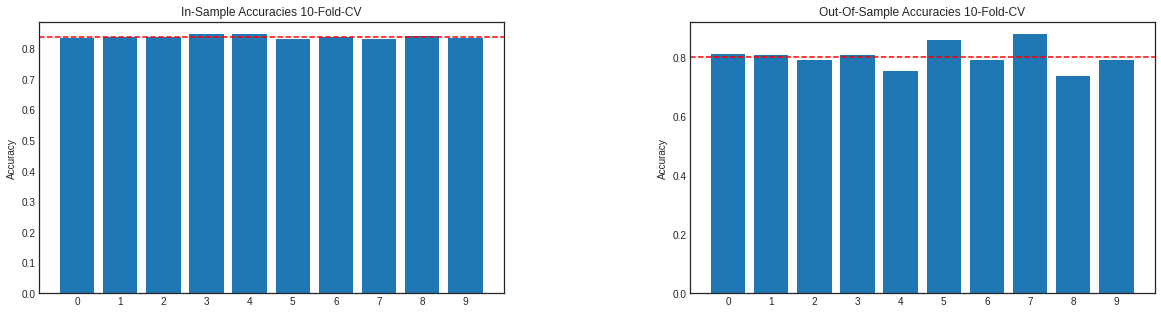

The in-sample mean accuracy is 83.81%. 
 The out-of-sample mean accuracy is 80.21%


In [0]:
pipe_svm = make_pipeline(StandardScaler(), SVC())

cv = cross_validate(pipe_svm, X_train, y_train, cv = 10, return_train_score= True, return_estimator= True)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv["train_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("In-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["train_score"].mean(), c = "red", ls = "--")


fig.add_subplot(1, 2, 2)
plt.bar(height = cv["test_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("Out-Of-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["test_score"].mean(), c = "red", ls = "--")
plt.show()

print("The in-sample mean accuracy is {:.2f}%. \n The out-of-sample mean accuracy is {:.2f}%".format(cv["train_score"].mean()*100, cv["test_score"].mean()*100))

### 5.3 Decision Tree

In [0]:
dt_model = DecisionTreeClassifier()

dt_fit = dt_model.fit(X_train, y_train)

dt_predict_train = dt_fit.predict(X_train)
dt_predict_test  = dt_fit.predict(X_test)

print("The Decision Tree Classification Report In-Sample: \n \n {}".format(classification_report(y_true = y_train, y_pred = dt_predict_train)))
print("\n The Decision Tree Classification Report Out-Of-Sample: \n \n {}".format(classification_report(y_true = y_test, y_pred = dt_predict_test)))

The Logistic Regression Classification Report In-Sample: 
 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       346
           1       1.00      0.97      0.98       225

    accuracy                           0.99       571
   macro avg       0.99      0.98      0.99       571
weighted avg       0.99      0.99      0.99       571


 The Logistic Regression Classification Report Out-Of-Sample: 
 
               precision    recall  f1-score   support

           0       0.86      0.82      0.84        78
           1       0.80      0.85      0.82        65

    accuracy                           0.83       143
   macro avg       0.83      0.83      0.83       143
weighted avg       0.83      0.83      0.83       143



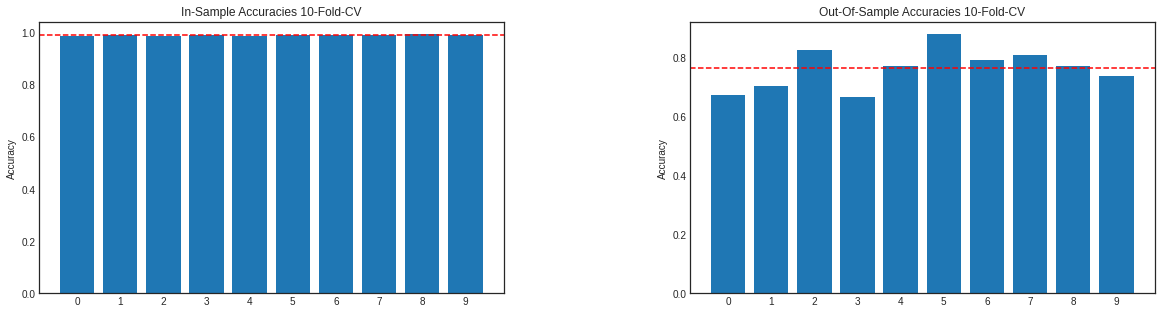

The in-sample mean accuracy is 98.85%. 
 The out-of-sample mean accuracy is 76.20%


In [0]:
pipe_dt = make_pipeline(StandardScaler(), DecisionTreeClassifier())

cv = cross_validate(pipe_dt, X_train, y_train, cv = 10, return_train_score= True, return_estimator= True)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv["train_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("In-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["train_score"].mean(), c = "red", ls = "--")


fig.add_subplot(1, 2, 2)
plt.bar(height = cv["test_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("Out-Of-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["test_score"].mean(), c = "red", ls = "--")
plt.show()

print("The in-sample mean accuracy is {:.2f}%. \n The out-of-sample mean accuracy is {:.2f}%".format(cv["train_score"].mean()*100, cv["test_score"].mean()*100))

### 5.4 KNN

In [0]:
knn_model = KNeighborsClassifier()

knn_fit = knn_model.fit(X_train, y_train)

knn_predict_train = knn_fit.predict(X_train)
knn_predict_test  = knn_fit.predict(X_test)

print("The KNN Classification Report In-Sample: \n \n {}".format(classification_report(y_true = y_train, y_pred = knn_predict_train)))
print("\n The KNN Classification Report Out-Of-Sample: \n \n {}".format(classification_report(y_true = y_test, y_pred = knn_predict_test)))

The Logistic Regression Classification Report In-Sample: 
 
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       346
           1       0.76      0.67      0.71       225

    accuracy                           0.78       571
   macro avg       0.78      0.76      0.77       571
weighted avg       0.78      0.78      0.78       571


 The Logistic Regression Classification Report Out-Of-Sample: 
 
               precision    recall  f1-score   support

           0       0.65      0.76      0.70        78
           1       0.63      0.51      0.56        65

    accuracy                           0.64       143
   macro avg       0.64      0.63      0.63       143
weighted avg       0.64      0.64      0.64       143



### 5.5 Ada Boost

In [0]:
ada_model = AdaBoostClassifier()

ada_fit = ada_model.fit(X_train, y_train)

ada_predict_train = ada_fit.predict(X_train)
ada_predict_test = ada_fit.predict(X_test)

print("The Ada Boost Classification Report In-Sample: \n \n {}".format(classification_report(y_true = y_train, y_pred = ada_predict_train)))
print("\n The Ada Boost Classification Report Out-Of-Sample: \n \n {}".format(classification_report(y_true = y_test, y_pred = ada_predict_test)))

The Support Vector Machine Classification Report In-Sample: 
 
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       346
           1       0.83      0.76      0.79       225

    accuracy                           0.84       571
   macro avg       0.84      0.83      0.83       571
weighted avg       0.84      0.84      0.84       571


 The Support Vector Machine Classification Report Out-Of-Sample: 
 
               precision    recall  f1-score   support

           0       0.84      0.85      0.84        78
           1       0.81      0.80      0.81        65

    accuracy                           0.83       143
   macro avg       0.82      0.82      0.82       143
weighted avg       0.83      0.83      0.83       143



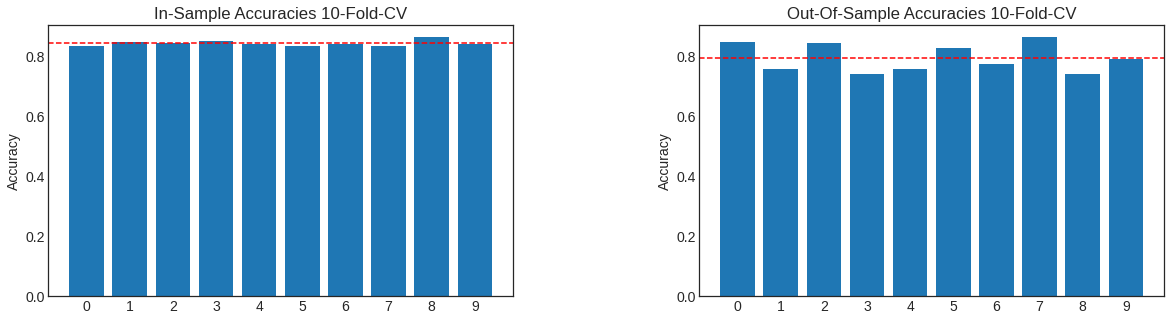

The in-sample mean accuracy is 84.22%. 
 The out-of-sample mean accuracy is 79.15%


In [0]:
pipe_ada = make_pipeline(StandardScaler(), AdaBoostClassifier())

cv = cross_validate(pipe_ada, X_train, y_train, cv = 10, return_train_score= True, return_estimator= True)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv["train_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("In-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["train_score"].mean(), c = "red", ls = "--")


fig.add_subplot(1, 2, 2)
plt.bar(height = cv["test_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("Out-Of-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["test_score"].mean(), c = "red", ls = "--")
plt.show()

print("The in-sample mean accuracy is {:.2f}%. \n The out-of-sample mean accuracy is {:.2f}%".format(cv["train_score"].mean()*100, cv["test_score"].mean()*100))

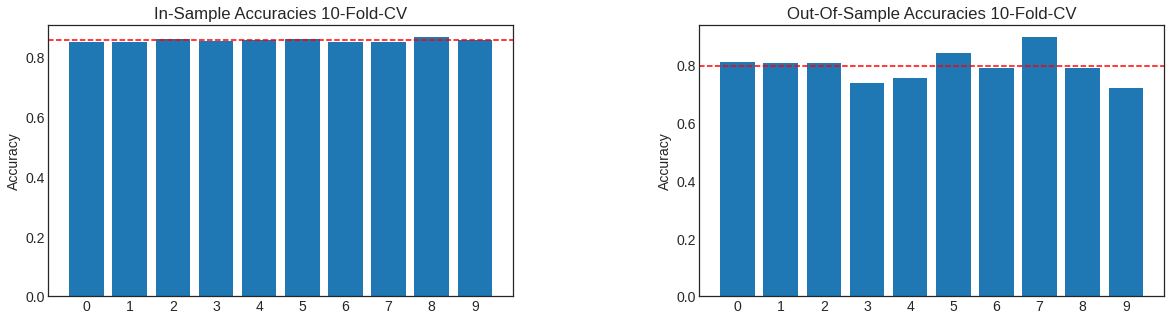

The in-sample mean accuracy is 85.41%. 
 The out-of-sample mean accuracy is 79.51%


In [0]:
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())

cv = cross_validate(pipe_knn, X_train, y_train, cv = 10, return_train_score= True, return_estimator= True)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv["train_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("In-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["train_score"].mean(), c = "red", ls = "--")


fig.add_subplot(1, 2, 2)
plt.bar(height = cv["test_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("Out-Of-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["test_score"].mean(), c = "red", ls = "--")
plt.show()

print("The in-sample mean accuracy is {:.2f}%. \n The out-of-sample mean accuracy is {:.2f}%".format(cv["train_score"].mean()*100, cv["test_score"].mean()*100))

### 5.6 Bagging - Logistic Regression

In [0]:
bagged_logit = BaggingClassifier(LogisticRegression(), max_samples=0.5, max_features=0.5)

bagged_logit_fit = bagged_logit.fit(X_train, y_train)


bagged_logit_predict_train = bagged_logit_fit.predict(X_train)
bagged_logit_predict_test  = bagged_logit_fit.predict(X_test)

print("The Bagged Logit Classification Report In-Sample: \n \n {}".format(classification_report(y_true = y_train, y_pred = bagged_logit_predict_train)))
print("\n The Bagged Logit Classification Report Out-Of-Sample: \n \n {}".format(classification_report(y_true = y_test, y_pred = bagged_logit_predict_test)))

The Support Vector Machine Classification Report In-Sample: 
 
               precision    recall  f1-score   support

           0       0.77      0.92      0.84       346
           1       0.82      0.57      0.68       225

    accuracy                           0.78       571
   macro avg       0.79      0.75      0.76       571
weighted avg       0.79      0.78      0.77       571


 The Support Vector Machine Classification Report Out-Of-Sample: 
 
               precision    recall  f1-score   support

           0       0.77      0.91      0.84        78
           1       0.86      0.68      0.76        65

    accuracy                           0.80       143
   macro avg       0.82      0.79      0.80       143
weighted avg       0.81      0.80      0.80       143



### 5.7 Neural Network

In [0]:
nn_model = MLPClassifier()

nn_fit = nn_model.fit(X_train, y_train)

nn_predict_train = nn_fit.predict(X_train)
nn_predict_test = nn_fit.predict(X_test)

print("The Support Vector Machine Classification Report In-Sample: \n \n {}".format(classification_report(y_true = y_train, y_pred = nn_predict_train)))
print("\n The Support Vector Machine Classification Report Out-Of-Sample: \n \n {}".format(classification_report(y_true = y_test, y_pred = nn_predict_test)))

The Support Vector Machine Classification Report In-Sample: 
 
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       346
           1       0.80      0.69      0.74       225

    accuracy                           0.81       571
   macro avg       0.81      0.79      0.80       571
weighted avg       0.81      0.81      0.81       571


 The Support Vector Machine Classification Report Out-Of-Sample: 
 
               precision    recall  f1-score   support

           0       0.82      0.81      0.81        78
           1       0.77      0.78      0.78        65

    accuracy                           0.80       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.80      0.80      0.80       143



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


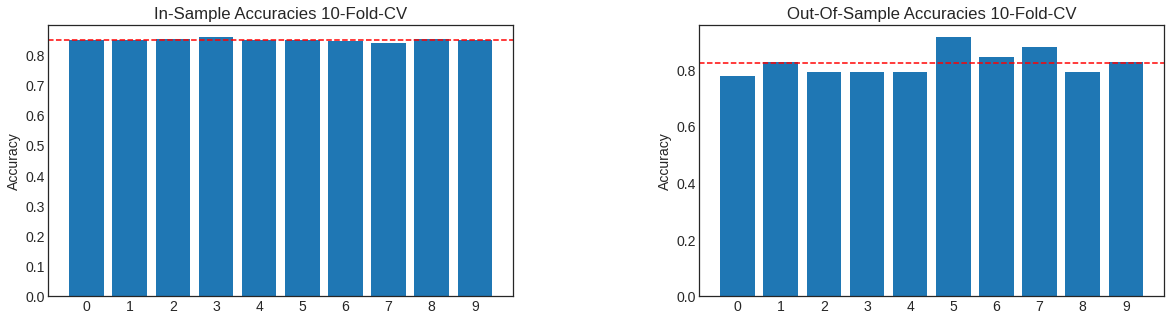

The in-sample mean accuracy is 84.76%. 
 The out-of-sample mean accuracy is 82.14%


In [0]:
pipe_nn = make_pipeline(StandardScaler(), MLPClassifier())

cv = cross_validate(pipe_nn, X_train, y_train, cv = 10, return_train_score= True, return_estimator= True)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

fig.add_subplot(1, 2, 1)
plt.bar(height = cv["train_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("In-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["train_score"].mean(), c = "red", ls = "--")


fig.add_subplot(1, 2, 2)
plt.bar(height = cv["test_score"], x = np.arange(10))
plt.xticks(np.arange(10))
plt.ylabel("Accuracy")
plt.title("Out-Of-Sample Accuracies 10-Fold-CV")
plt.axhline(cv["test_score"].mean(), c = "red", ls = "--")
plt.show()

print("The in-sample mean accuracy is {:.2f}%. \n The out-of-sample mean accuracy is {:.2f}%".format(cv["train_score"].mean()*100, cv["test_score"].mean()*100))

## 6. Evaluation